# DTSA 5511 - Deep Learning - CNN Cancer Detection Mini-Project

---
### Contents
1. Setup and imports
2. Introduction and overview of the problem
3. Description of the data and EDA
4. Data preparation
5. Modeling
6. Results and analysis

---
### 1. Setup and imports

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
gpu_count = 0
if gpu_info.find('command not found') >= 0:
  print('CUDA not installed')
elif gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
  gpu_count = !nvidia-smi -L | wc -l
print('GPU count:', gpu_count)

Sun Mar 24 14:20:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from google.colab import userdata, files, drive
# drive.mount('/content/drive')
import os
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
import kaggle

In [39]:
# !mkdir /root/.kaggle
# !cp /content/drive/MyDrive/kaggle/kaggle.json /root/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json
# !kaggle competitions download -c nlp-getting-started
!unzip -o -q /content/drive/MyDrive/kaggle/nlp_tweets/nlp-getting-started.zip -d /content/nlp_data/

In [4]:
import numpy as np
import pandas as pd
import re
import string
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from joblib import dump, load
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping

---
### 2. Introduction and overview of the problem

This competition presents us with a collection of tweets, some of which are about real disasters, while others are not. The tricky thing is that some of the non-disaster tweets use words that may be common with disaster tweets. Our job is to distinguish one from the other.

We will start by looking at the data, performing some EDA and data visualization. Then we will use two different recurrent neural network architectures to attempt to classify the tweets. The two RNNs we will use are Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU).

We will experiment with different architectures and hyper-parameters until we are happy with the classification performance. Then we will do predictions on the test dataset and submit our predictions to Kaggle for scoring.

---
### 3. Description of the data and EDA

The training dataset consists of 7613 observations by 5 columns. The 5 columns are an id, a keyword that is extracted from the text of the tweet, some location data, the text of the tweet itself and a target column indicating whether the tweet was hand-classified as being related to a real disaster or not.

The keyword column doesn't have a lot of missing data, and spot-checking a few shows that it seems to be relevant to the text of the tweet. This feature could be useful for topic modeling or sentiment analysis, but doesn't seem very relevant to understand if the tweet is about a real disaster or not. I will ignore this column and focus on the text of the tweet which should have richer and more detailed information that the single keyword column.

The location column is about 1/3 null and manual inspection of the contents show that it is a mixed bag of countries, cities, with inconsistent format and even quite a few examples that have nothing to do with location. Since this column is quite dirty and doesn't seem obviously related to whether the tweet is about a real disaster, I will exclude it from my analysis.

Since this is a supervised classification problem, we need to look at class balance to determine if rebalancing is called for. In this case, there are 4300 negative cases and 3300 positive cases. Not perfectly balanced, but not enough to suggest we should take any corrective measures.

The histgram of the length of disaster tweets vs non-disaster tweets reveals two interesting observations. First is the peak for both types of tweets at 140 characters. This suggests that people were indeed constrained by the 140 character limit that existed in the early days of Twitter, and lends support to Twitter's decision to increase that limit to 280 characters in 2017. Second is that there are fewer short tweets about disasters and more disaster tweets tend to hit the 140 character limit.

In [5]:
sample_submission_df = pd.read_csv('/content/nlp_data/sample_submission.csv')
train_df = pd.read_csv('/content/nlp_data/train.csv')
test_df = pd.read_csv('/content/nlp_data/test.csv')

In [6]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
train_df['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [9]:
train_df['location'].value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

In [10]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [11]:
train_df['label_bool'] = train_df['target'].astype(bool)

In [12]:
fig = px.histogram(train_df, x='label_bool', histnorm='probability density')
fig.show()

In [13]:
train_df[~train_df['keyword'].isna()]

,id,keyword,location,text,target,label_bool
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,True
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,False
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,True
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,False
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,False
...,...,...,...,...,...,...
7578,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0,False
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0,False
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0,False
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0,False


In [14]:
train_df['location'].isna().sum()

2533

In [15]:
train_df['text_length'] = train_df['text'].apply(lambda x: len(x))

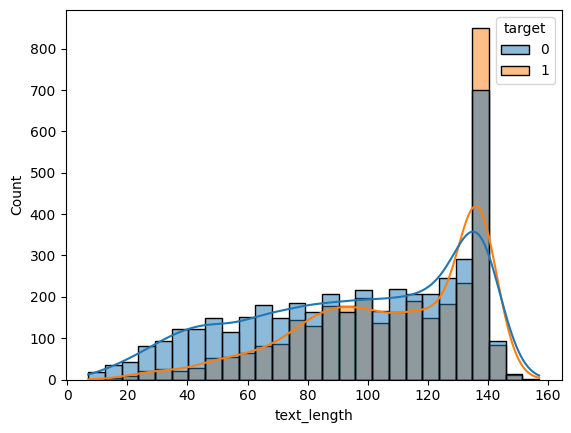

In [16]:
sns.histplot(data=train_df, x='text_length', hue='target', kde=True);

---
### 4. Data Preparation

Data preparation is critical for NLP applications. The text of the tweets needs to converted from text that humans use to communicate into numbers that a computer algorithm can make sense of. There is often a lot clean up that needs to be done as well, in order to remove extraneous data that could confuse and mislead the model.

If I were using traditional NLP techniques that rely on word counts, I would remove stop words that don't add any meaning to text. In this project, we are using more advanced embeddings and RNNs which may be able to understand more of the structure of the sentences in the text, so I will leave in the so-called connective stop words.

There were quite a few URLs and @ handles in the tweet text. I've removed these to prevent the model from interpreting these as meaningful text.

Once that is done, I tokenize the text, convert it to sequences, then pad it. Padding sequences so that they are all the same length is a common NLP technique that is often done for RNN-type models.

In [17]:
# Data cleaning
# Leave in stop words, remove hyperlinks, @mentions
def clean_text(text):
  text = text.lower()
  text = text.replace('\n', ' ')
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r'@\S+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
  return text

In [18]:
train_df['text_clean'] = train_df['text'].apply(clean_text)
test_df['text_clean'] = test_df['text'].apply(clean_text)

In [19]:
train_df[~train_df['keyword'].isna()]

,id,keyword,location,text,target,label_bool,text_length,text_clean
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,True,55,wholesale markets ablaze
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,False,67,we always try to bring the heavy metal rt
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,True,82,africanbaze breaking news nigeria flag set a...
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,False,34,crying out for more set me ablaze
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,False,76,on plus side look at the sky last night it was...
...,...,...,...,...,...,...,...,...
7578,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0,False,48,and i wrecked you both
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0,False,107,three days off from work and they ve pretty mu...
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0,False,93,fx forex trading cramer iger s 3 words tha...
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0,False,104,great atmosphere at the british lion gig toni...


In [20]:
y = train_df['target']
X_train, X_val, y_train, y_val = train_test_split(train_df, y, test_size=0.2, random_state=42)

In [21]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train['text_clean'])

seq_train = tokenizer.texts_to_sequences(X_train['text_clean'])
padded_train = pad_sequences(seq_train, maxlen=100)

seq_val = tokenizer.texts_to_sequences(X_val['text_clean'])
padded_val = pad_sequences(seq_val, maxlen=100)

seq_test = tokenizer.texts_to_sequences(test_df['text_clean'])
padded_test = pad_sequences(seq_test, maxlen=100)

In [22]:
padded_train.shape

(6090, 100)

In [23]:
num_tokens = len(tokenizer.word_index) + 1
num_tokens

13293

---
### 5. Modeling

I will use two different RNNs in this analysis, LSTM and GRU, trying different architectures to see how the performance changes.

The base model (`model`) had a single LSTM layer, followed by single dense layer. Since this is a binary classification problem, with all of the models, the final fully connected dense layer has a single output neuron with sigmoid activation and the optimizer uses the binary crossentropy loss function. Comparison of test accuracy vs validation accuracy shows strong over-fitting, so we will add strong regularization in the form of dropout in the next model.

The second model (`model_01`) switches to a bi-directional LSTM layer with 64 units and an aggressive 0.8 dropout, followed by a 2nd bi-directional LSTM layer with 32 units, followed by a 0.8 dropout layer. I also lowered the learning rate to 0.0005. This model had a significant improvement in validation accuracy over the baseline model but still shows some signs of overfitting.

The next model (`model_02`) returns to a single LSTM layer with 32 units, but goes with a less aggressive 0.5 dropout rate in the LSTM layer and in the stand-alone dropout layer. This model showed a slight improvement over the previous model and ended up being the best of the LSTM-based models.

In the next model (`model_03`), I tried to address the over-fitting by using a single LSTM model with even fewer units (16), but then added a small fully connected layer before the final output layer. The idea is to reduce the amount of data being created in the feature extraction section of the model, but increase the capacity of the classification section to learn complex patterns. This model seemed to over-fit a bit less than previous models, but did not achieve a higher accuracy score.

Next, I switched to GRUs. `model_04` is the baseline GRU model and has a single 128 unit GRU layer followed by a fully connected output layer. This model did not perform well, with the highest accuracy being achieved in the first epoch and degrading from there.

The next GRU model (`model_05`) follows the changes made from the baseline LSTM model to `model_01` by adding another GRU layer and aggressive dropout. This model performed quite well, with good peack accuracy and no pronounced dropoff in validation accuracy as the epochs advanced.

The final model (`model_06`) keeps most of the same architecture as `model_05`,but adds a 16 unit fully connected layer before the final output layer. Although there was dropoff in validation accuracy at the end of the training run, this model ended up being the best of the GRU models.

In [24]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

In [25]:
model = Sequential()
model.add(Embedding(num_tokens, 128))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

adam = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1701504   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1833217 (6.99 MB)
Trainable params: 1833217 (6.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
history = model.fit(padded_train, y_train, epochs=10, validation_data=(padded_val, y_val), callbacks=[early_stopping])

Epoch 1/10
191/191 [==============================] - 13s 51ms/step - loss: 0.5268 - accuracy: 0.7381 - val_loss: 0.4525 - val_accuracy: 0.8037
Epoch 2/10
191/191 [==============================] - 4s 18ms/step - loss: 0.3127 - accuracy: 0.8714 - val_loss: 0.4997 - val_accuracy: 0.7958
Epoch 3/10
191/191 [==============================] - 2s 9ms/step - loss: 0.2028 - accuracy: 0.9215 - val_loss: 0.5545 - val_accuracy: 0.7768
Epoch 4/10
191/191 [==============================] - 2s 12ms/step - loss: 0.1392 - accuracy: 0.9491 - val_loss: 0.7213 - val_accuracy: 0.7630
Epoch 5/10
191/191 [==============================] - 3s 17ms/step - loss: 0.1000 - accuracy: 0.9663 - val_loss: 0.7277 - val_accuracy: 0.7617
Epoch 6/10
191/191 [==============================] - 2s 9ms/step - loss: 0.0750 - accuracy: 0.9734 - val_loss: 0.8878 - val_accuracy: 0.7544
Epoch 7/10
191/191 [==============================] - 2s 8ms/step - loss: 0.0600 - accuracy: 0.9750 - val_loss: 0.9266 - val_accuracy: 0.7538
E

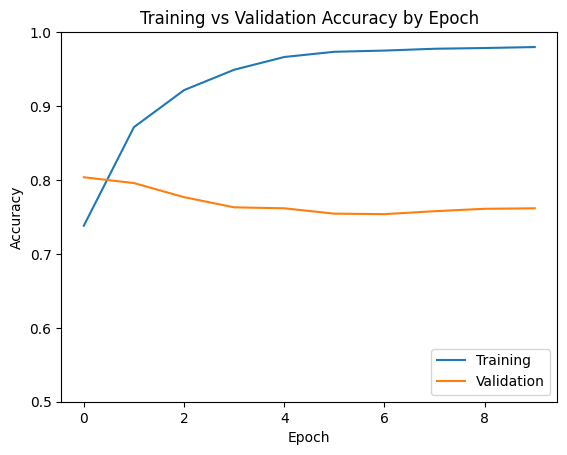

In [27]:
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.title('Training vs Validation Accuracy by Epoch')
plt.legend(loc='lower right')
plt.show()

In [29]:
model_01 = Sequential()
model_01.add(Embedding(num_tokens, 25, input_length=100))
model_01.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.8)))
model_01.add(Bidirectional(LSTM(32, dropout=0.8)))
model_01.add(Dropout(0.8))
# model_01.add(Dense(16, activation='relu'))
model_01.add(Dense(1, activation='sigmoid'))

adam = Adam(learning_rate=0.0005)
model_01.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

model_01.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 25)           332325    
                                                                 
 bidirectional_2 (Bidirecti  (None, 100, 128)          46080     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 419686 (1.60 MB)
Trainable params: 41968

In [30]:
history_01 = model_01.fit(padded_train, y_train, epochs=10, validation_data=(padded_val, y_val), callbacks=[early_stopping])

Epoch 1/10
191/191 [==============================] - 28s 105ms/step - loss: 0.6854 - accuracy: 0.5634 - val_loss: 0.6727 - val_accuracy: 0.5739
Epoch 2/10
191/191 [==============================] - 11s 58ms/step - loss: 0.6018 - accuracy: 0.6837 - val_loss: 0.4873 - val_accuracy: 0.7866
Epoch 3/10
191/191 [==============================] - 8s 42ms/step - loss: 0.4619 - accuracy: 0.8069 - val_loss: 0.4469 - val_accuracy: 0.8050
Epoch 4/10
191/191 [==============================] - 5s 28ms/step - loss: 0.3908 - accuracy: 0.8478 - val_loss: 0.4678 - val_accuracy: 0.7925
Epoch 5/10
191/191 [==============================] - 5s 24ms/step - loss: 0.3487 - accuracy: 0.8680 - val_loss: 0.4430 - val_accuracy: 0.8129
Epoch 6/10
191/191 [==============================] - 5s 24ms/step - loss: 0.3155 - accuracy: 0.8829 - val_loss: 0.4576 - val_accuracy: 0.8116
Epoch 7/10
191/191 [==============================] - 5s 25ms/step - loss: 0.2876 - accuracy: 0.8972 - val_loss: 0.4846 - val_accuracy: 0.7

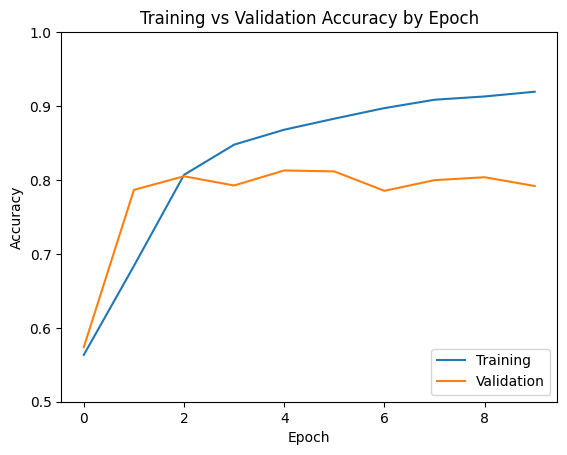

In [31]:
plt.plot(history_01.history['accuracy'], label='Training')
plt.plot(history_01.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.title('Training vs Validation Accuracy by Epoch')
plt.legend(loc='lower right')
plt.show()

In [32]:
model_02 = Sequential()
model_02.add(Embedding(num_tokens, 25, input_length=100))
# model_02.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.5)))
model_02.add(Bidirectional(LSTM(32, dropout=0.5)))
model_02.add(Dropout(0.5))
# model_02.add(Dense(16, activation='relu'))
model_02.add(Dense(1, activation='sigmoid'))

adam = Adam(learning_rate=0.0005)
model_02.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

model_02.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 25)           332325    
                                                                 
 bidirectional_4 (Bidirecti  (None, 64)                14848     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 347238 (1.32 MB)
Trainable params: 347238 (1.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
history = model_02.fit(padded_train, y_train, epochs=10, validation_data=(padded_val, y_val), callbacks=[early_stopping])

Epoch 1/10
191/191 [==============================] - 17s 67ms/step - loss: 0.6727 - accuracy: 0.5814 - val_loss: 0.6263 - val_accuracy: 0.6310
Epoch 2/10
191/191 [==============================] - 4s 22ms/step - loss: 0.5159 - accuracy: 0.7727 - val_loss: 0.4581 - val_accuracy: 0.8024
Epoch 3/10
191/191 [==============================] - 4s 20ms/step - loss: 0.3872 - accuracy: 0.8432 - val_loss: 0.4364 - val_accuracy: 0.8155
Epoch 4/10
191/191 [==============================] - 3s 16ms/step - loss: 0.3244 - accuracy: 0.8721 - val_loss: 0.4395 - val_accuracy: 0.8181
Epoch 5/10
191/191 [==============================] - 3s 16ms/step - loss: 0.2715 - accuracy: 0.8989 - val_loss: 0.4588 - val_accuracy: 0.8096
Epoch 6/10
191/191 [==============================] - 3s 18ms/step - loss: 0.2462 - accuracy: 0.9102 - val_loss: 0.4605 - val_accuracy: 0.8102
Epoch 7/10
191/191 [==============================] - 3s 14ms/step - loss: 0.2115 - accuracy: 0.9218 - val_loss: 0.5168 - val_accuracy: 0.799

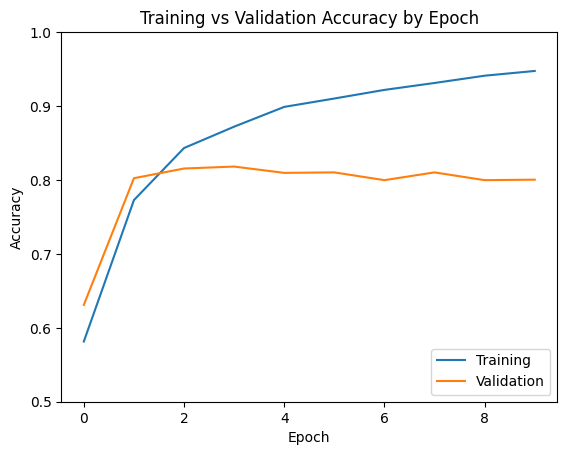

In [34]:
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.title('Training vs Validation Accuracy by Epoch')
plt.legend(loc='lower right')
plt.show()

In [40]:
model_03 = Sequential()
model_03.add(Embedding(num_tokens, 25, input_length=100))
# model_02.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.5)))
model_03.add(Bidirectional(LSTM(16, dropout=0.5)))
model_03.add(Dropout(0.5))
model_03.add(Dense(8, activation='relu'))
model_03.add(Dropout(0.5))
model_03.add(Dense(1, activation='sigmoid'))

adam = Adam(learning_rate=0.0005)
model_03.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

model_03.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 25)           332325    
                                                                 
 bidirectional_5 (Bidirecti  (None, 32)                5376      
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 8)                 264       
                                                                 
 dropout_4 (Dropout)         (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                      

In [41]:
history = model_03.fit(padded_train, y_train, epochs=10, validation_data=(padded_val, y_val), callbacks=[early_stopping])

Epoch 1/10
191/191 [==============================] - 16s 61ms/step - loss: 0.6847 - accuracy: 0.5649 - val_loss: 0.6708 - val_accuracy: 0.5739
Epoch 2/10
191/191 [==============================] - 6s 33ms/step - loss: 0.6473 - accuracy: 0.5842 - val_loss: 0.5998 - val_accuracy: 0.7196
Epoch 3/10
191/191 [==============================] - 3s 15ms/step - loss: 0.5482 - accuracy: 0.7461 - val_loss: 0.4929 - val_accuracy: 0.7978
Epoch 4/10
191/191 [==============================] - 3s 17ms/step - loss: 0.4319 - accuracy: 0.8177 - val_loss: 0.4514 - val_accuracy: 0.8063
Epoch 5/10
191/191 [==============================] - 4s 19ms/step - loss: 0.3606 - accuracy: 0.8591 - val_loss: 0.4483 - val_accuracy: 0.8116
Epoch 6/10
191/191 [==============================] - 3s 16ms/step - loss: 0.3267 - accuracy: 0.8709 - val_loss: 0.4655 - val_accuracy: 0.7925
Epoch 7/10
191/191 [==============================] - 3s 14ms/step - loss: 0.2894 - accuracy: 0.8938 - val_loss: 0.5094 - val_accuracy: 0.801

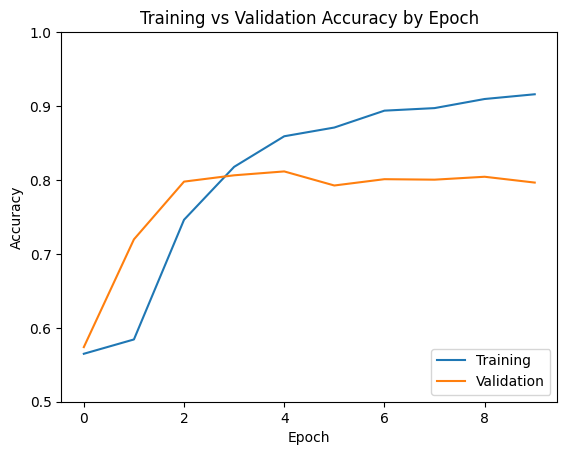

In [42]:
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.title('Training vs Validation Accuracy by Epoch')
plt.legend(loc='lower right')
plt.show()

In [43]:
model_04 = Sequential()
model_04.add(Embedding(num_tokens, 128))
model_04.add(GRU(128))
model_04.add(Dense(1, activation='sigmoid'))

adam = Adam(learning_rate=0.001)
model_04.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

model_04.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 128)         1701504   
                                                                 
 gru (GRU)                   (None, 128)               99072     
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1800705 (6.87 MB)
Trainable params: 1800705 (6.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
history_04 = model_04.fit(padded_train, y_train, epochs=10, validation_data=(padded_val, y_val), callbacks=[early_stopping])

Epoch 1/10
191/191 [==============================] - 11s 46ms/step - loss: 0.5230 - accuracy: 0.7435 - val_loss: 0.4510 - val_accuracy: 0.7971
Epoch 2/10
191/191 [==============================] - 4s 22ms/step - loss: 0.3076 - accuracy: 0.8750 - val_loss: 0.4925 - val_accuracy: 0.7925
Epoch 3/10
191/191 [==============================] - 3s 15ms/step - loss: 0.1968 - accuracy: 0.9255 - val_loss: 0.5711 - val_accuracy: 0.7630
Epoch 4/10
191/191 [==============================] - 2s 12ms/step - loss: 0.1281 - accuracy: 0.9539 - val_loss: 0.6485 - val_accuracy: 0.7708
Epoch 5/10
191/191 [==============================] - 2s 10ms/step - loss: 0.0971 - accuracy: 0.9662 - val_loss: 0.7355 - val_accuracy: 0.7649
Epoch 6/10
191/191 [==============================] - 2s 10ms/step - loss: 0.0750 - accuracy: 0.9744 - val_loss: 0.7869 - val_accuracy: 0.7630
Epoch 7/10
191/191 [==============================] - 2s 12ms/step - loss: 0.0601 - accuracy: 0.9787 - val_loss: 0.8578 - val_accuracy: 0.768

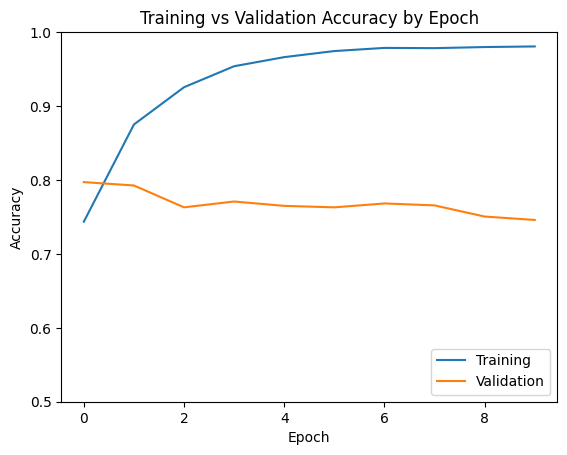

In [45]:
plt.plot(history_04.history['accuracy'], label='Training')
plt.plot(history_04.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.title('Training vs Validation Accuracy by Epoch')
plt.legend(loc='lower right')
plt.show()

In [46]:
model_05 = Sequential()
model_05.add(Embedding(num_tokens, 25, input_length=100))
model_05.add(Bidirectional(GRU(64, return_sequences=True, dropout=0.8)))
model_05.add(Bidirectional(GRU(32, dropout=0.8)))
model_05.add(Dropout(0.8))
# model_01.add(Dense(16, activation='relu'))
model_05.add(Dense(1, activation='sigmoid'))

adam = Adam(learning_rate=0.0005)
model_05.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

model_05.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 25)           332325    
                                                                 
 bidirectional_6 (Bidirecti  (None, 100, 128)          34944     
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 64)                31104     
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 398438 (1.52 MB)
Trainable params: 39843

In [47]:
history_05 = model_05.fit(padded_train, y_train, epochs=10, validation_data=(padded_val, y_val), callbacks=[early_stopping])

Epoch 1/10
191/191 [==============================] - 26s 80ms/step - loss: 0.6866 - accuracy: 0.5608 - val_loss: 0.6813 - val_accuracy: 0.5739
Epoch 2/10
191/191 [==============================] - 5s 29ms/step - loss: 0.6832 - accuracy: 0.5734 - val_loss: 0.6768 - val_accuracy: 0.5739
Epoch 3/10
191/191 [==============================] - 6s 29ms/step - loss: 0.6291 - accuracy: 0.6493 - val_loss: 0.5091 - val_accuracy: 0.7669
Epoch 4/10
191/191 [==============================] - 4s 20ms/step - loss: 0.4823 - accuracy: 0.7865 - val_loss: 0.4708 - val_accuracy: 0.7820
Epoch 5/10
191/191 [==============================] - 4s 22ms/step - loss: 0.4038 - accuracy: 0.8379 - val_loss: 0.4514 - val_accuracy: 0.7978
Epoch 6/10
191/191 [==============================] - 4s 23ms/step - loss: 0.3579 - accuracy: 0.8603 - val_loss: 0.4586 - val_accuracy: 0.7978
Epoch 7/10
191/191 [==============================] - 4s 21ms/step - loss: 0.3170 - accuracy: 0.8811 - val_loss: 0.4835 - val_accuracy: 0.803

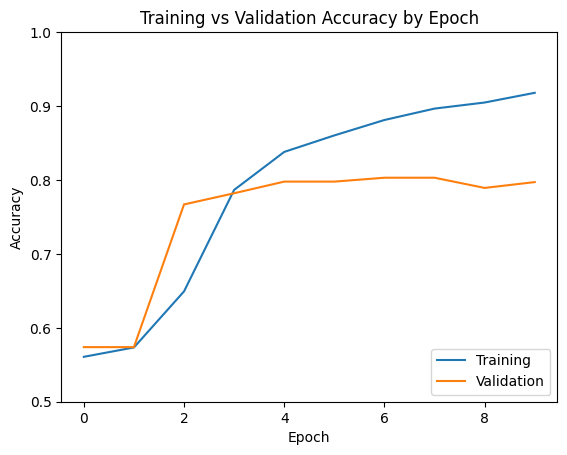

In [48]:
plt.plot(history_05.history['accuracy'], label='Training')
plt.plot(history_05.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.title('Training vs Validation Accuracy by Epoch')
plt.legend(loc='lower right')
plt.show()

In [49]:
model_06 = Sequential()
model_06.add(Embedding(num_tokens, 25, input_length=100))
model_06.add(Bidirectional(GRU(64, return_sequences=True, dropout=0.8)))
model_06.add(Bidirectional(GRU(32, dropout=0.8)))
model_06.add(Dropout(0.8))
model_06.add(Dense(16, activation='relu'))
model_06.add(Dense(1, activation='sigmoid'))

adam = Adam(learning_rate=0.0005)
model_06.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

model_06.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 25)           332325    
                                                                 
 bidirectional_8 (Bidirecti  (None, 100, 128)          34944     
 onal)                                                           
                                                                 
 bidirectional_9 (Bidirecti  (None, 64)                31104     
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 16)                1040      
                                                                 
 dense_9 (Dense)             (None, 1)                

In [50]:
history_06 = model_06.fit(padded_train, y_train, epochs=10, validation_data=(padded_val, y_val), callbacks=[early_stopping])

Epoch 1/10
191/191 [==============================] - 25s 91ms/step - loss: 0.6873 - accuracy: 0.5588 - val_loss: 0.6811 - val_accuracy: 0.5739
Epoch 2/10
191/191 [==============================] - 6s 31ms/step - loss: 0.6816 - accuracy: 0.5719 - val_loss: 0.6628 - val_accuracy: 0.5739
Epoch 3/10
191/191 [==============================] - 5s 25ms/step - loss: 0.5708 - accuracy: 0.7179 - val_loss: 0.4689 - val_accuracy: 0.8030
Epoch 4/10
191/191 [==============================] - 5s 28ms/step - loss: 0.4377 - accuracy: 0.8222 - val_loss: 0.4427 - val_accuracy: 0.8050
Epoch 5/10
191/191 [==============================] - 6s 30ms/step - loss: 0.3796 - accuracy: 0.8484 - val_loss: 0.4482 - val_accuracy: 0.8096
Epoch 6/10
191/191 [==============================] - 5s 25ms/step - loss: 0.3439 - accuracy: 0.8693 - val_loss: 0.4600 - val_accuracy: 0.8037
Epoch 7/10
191/191 [==============================] - 7s 35ms/step - loss: 0.3046 - accuracy: 0.8846 - val_loss: 0.4725 - val_accuracy: 0.812

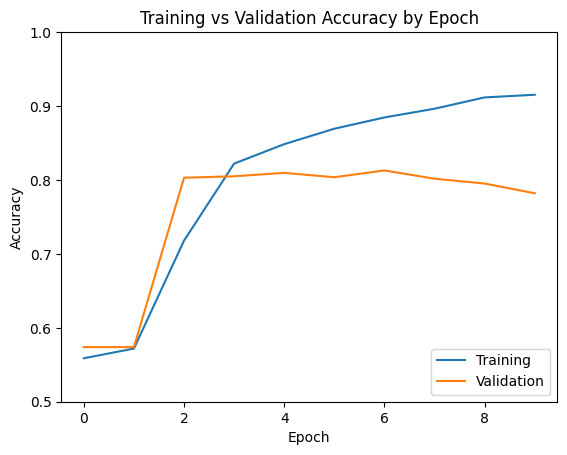

In [51]:
plt.plot(history_06.history['accuracy'], label='Training')
plt.plot(history_06.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.title('Training vs Validation Accuracy by Epoch')
plt.legend(loc='lower right')
plt.show()

---
### 6. Results and Analysis

The summary of the models and the accuracy scores is shown below.

| Model  | Best val_acc | Final val_acc | Seconds per epoch |
|--------|--------------|---------------|-------------------|
| 0 (LSTM) | 0.8037       | 0.7617        | 2                 |
| 1 (LSTM) | 0.8129       | 0.7919        | 5                 |
| 2 (LSTM) | 0.8181       | 0.8004        | 3                 |
| 3 (LSTM) | 0.8116       | 0.7965        | 3                 |
|  4 (GRU) | 0.7971       | 0.7459        | 2                 |
|  5 (GRU) | 0.8030       | 0.7371        | 4                 |
|  6 (GRU) | 0.8129       | 0.7820        | 4                 |

Overall, LSTM-based models and GRU-based models performed quite similarly. I chose models 1, 2 and 6 to generate predictions to submit to Kaggle. The best Kaggle public score came from model 6 with a score of 0.79313.

Since GRUs have a simpler construction than LSTMs, I was expecting them to train quicker, so I tracked the rough average duration of the training epochs. These are reported in the last column of the table. Despite their simpler internal structure, the GRU-based models did not train any quicker than LSTM-based models with similar parameter counts.


In [55]:
preds_01 = model_01.predict(padded_test)
preds_06 = model_06.predict(padded_test)

102/102 [==============================] - 1s 9ms/step


In [35]:
preds_02 = model_02.predict(padded_test)

102/102 [==============================] - 1s 5ms/step


In [43]:
preds_01.shape

(3263, 1)

In [42]:
test_df

,id,keyword,location,text,text_clean
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard about earthquake is different cities s...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 in china and taiwan
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,earthquake safety los angeles ûò safety faste...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,storm in ri worse than last hurricane my city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,green line derailment in chicago
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issues hazardous weather outlook hwo


In [36]:
submission_df = pd.DataFrame(test_df['id'].copy())
submission_df['target'] = (preds_02 > 0.4).astype(int)

submission_df

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [37]:
submission_df['target'].value_counts()

0    1915
1    1348
Name: target, dtype: int64

In [38]:
submission_df.to_csv('/content/drive/MyDrive/kaggle/nlp_tweets/submission_02.csv', index=False)